In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
session_info = {'date': "23_01_2025",
                'genotype_dir': 'R18B05LexA_jGCaMP8s_R60D05Gal4_jRGECO1a',
                'fly': 'fly3',
                'session': 'closed_loop-002',
                'full_genotype': '',
                'ecl date': '',
                'fictrac_scan_num':2,
                'fictrac_dat_file' : 'fictrac-20250123_115735.dat',
                'notes':''}


session_info['fictrac_dir']= f"/media/mplitt/SSD_storage/fictrac_folder/{session_info['genotype_dir']}/{session_info['date']}/{session_info['fly']}"
bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
# pkl_path = pathlib.PurePath(f"/media/mplitt/SSD_storage/fictrac_folder/{session_info['genotype_dir']}/{session_info['date']}/{session_info['fly']}/fly1_1_scan0.pkl")

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_dir = session_info['fictrac_dir'],
                                         fictrac_dat_file = session_info['fictrac_dat_file'],
                                         fictrac_scan_num = session_info['fictrac_scan_num'])
                                         # fictrac_pkl_path=pkl_path)

In [3]:
pp.extract_metadata()
pp.align_voltage_recording()



In [4]:
pp.align_fictrac()

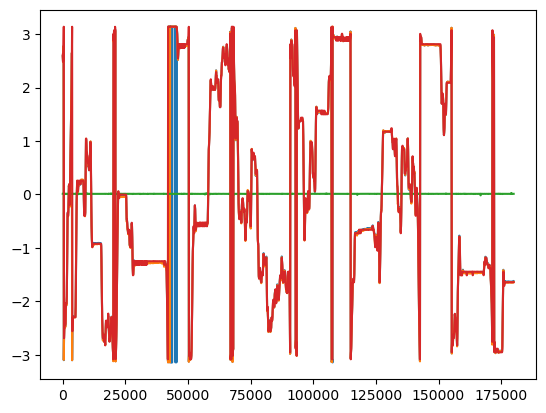

In [5]:
fig, ax = plt.subplots()
time = pp.fictrac_aligned['Time(ms)']
inds = slice(0,100000)
ax.plot(time[inds],pp.fictrac_aligned['integ heading (lab)'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Heading'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Y/Index'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Arena DAC1'].iloc[inds])

In [6]:

pp.bruker_to_h5(first_chan=1, overwrite=False)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)



In [7]:
nap = pp.open_napari()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


In [8]:
print()

In [9]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)

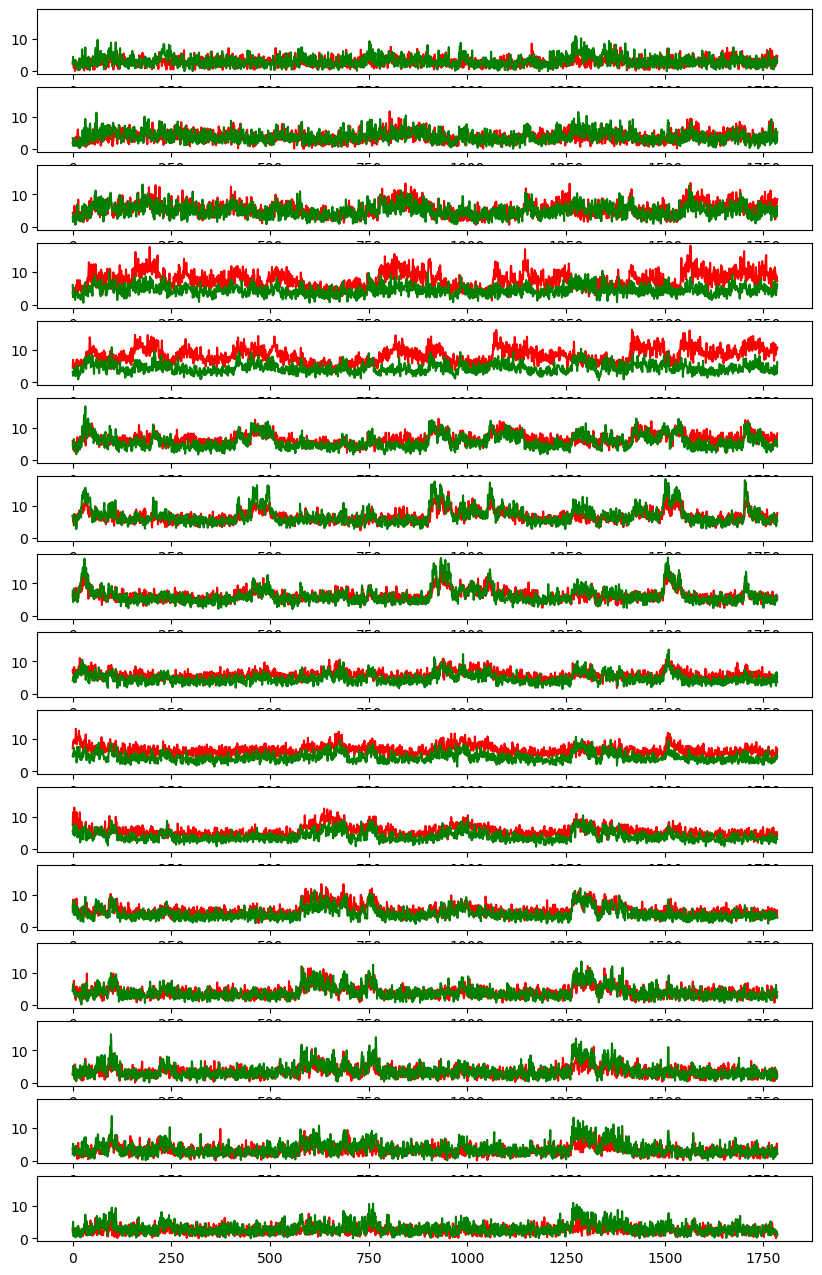

In [10]:
fig,ax = plt.subplots(16,1, figsize=[10,16],sharey=True)
for r in range(n_rois):
    ax[r].plot(pp.timeseries['rois'][0,r,:], color='red')
    ax[r].plot(pp.timeseries['rois'][1,r,:], color='green')


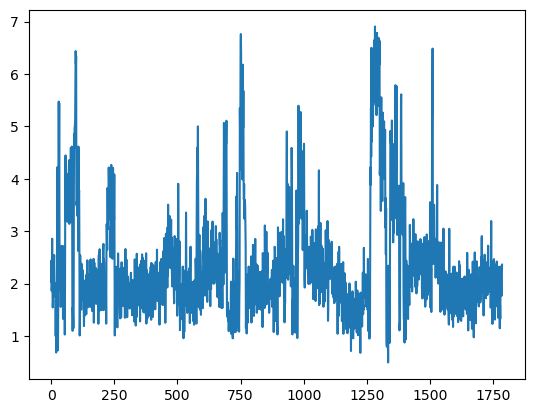

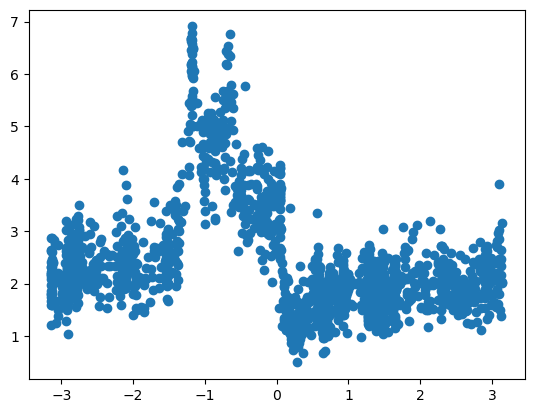

In [11]:
fig, ax= plt.subplots()
ax.plot(pp.timeseries['background'][-1,0,:])
fig, ax= plt.subplots()
heading = -1* pp.voltage_recording_aligned[' Heading'].to_numpy()
ax.scatter(heading, pp.timeseries['background'][-1,0,:])

In [12]:
# y = pp.calculate_zscored_F('rois', exp_detrend=False, zscore=False, background_ts='background')-1
y = pp.calculate_zscored_F('rois', exp_detrend=False, zscore=True, background_ts='background')

In [13]:
pp.save()

In [14]:
if False:
    gd = session_info['genotype_dir']
    d = session_info['date']
    f = session_info['fly']
    s = session_info['session']
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    print(outdir)
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    y = pp.timeseries['rois_z']
    n_rois=y.shape[1]
    heading = -1* pp.voltage_recording_aligned[' Heading'].to_numpy()

In [15]:
y_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y, 2, axis=-1),.7,axis=1, mode='wrap')

In [16]:
x_f_green, y_f_green = st2p.utilities.pol2cart(y_sm[1,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
rho_green,phi_green = st2p.utilities.cart2pol(x_f_green.mean(axis=0), y_f_green.mean(axis=0))


x_f_red, y_f_red = st2p.utilities.pol2cart(y_sm[0,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
rho_red,phi_red = st2p.utilities.cart2pol(x_f_red.mean(axis=0), y_f_red.mean(axis=0))



_,offset_green = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi_green-heading))
_,offset_red = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi_red-heading))
print(offset_green, offset_red)

[-2.47746041 -2.61562716 -2.63297096 ...  2.64297023  2.93796805
  3.05534343] [-2.55863664 -2.66098994 -2.6149633  ...  2.72833412  2.72261991
  2.74482491]


0.30876389743656363


(array([  12.,   24.,   60.,  118., 1167.,  293.,   58.,   35.,   17.,
           2.]),
 array([-0.63822066, -0.50534218, -0.3724637 , -0.23958522, -0.10670674,
         0.02617174,  0.15905022,  0.2919287 ,  0.42480718,  0.55768566,
         0.69056414]),
 <BarContainer object of 10 artists>)

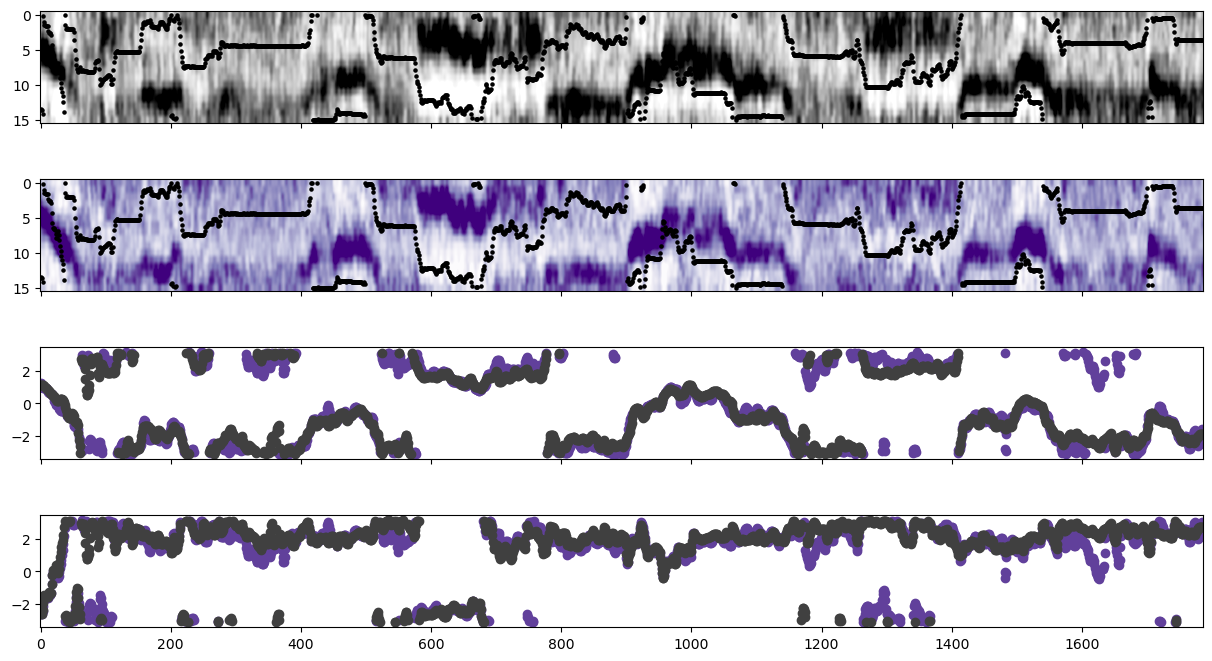

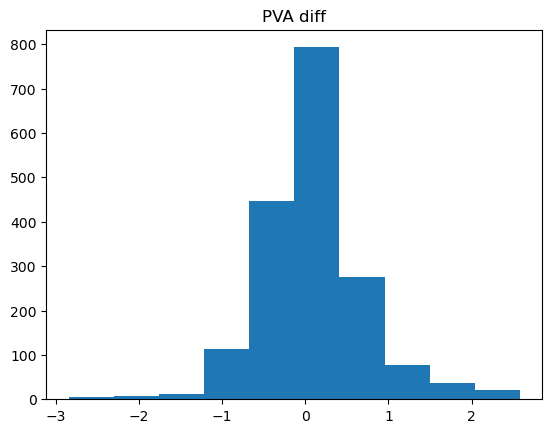

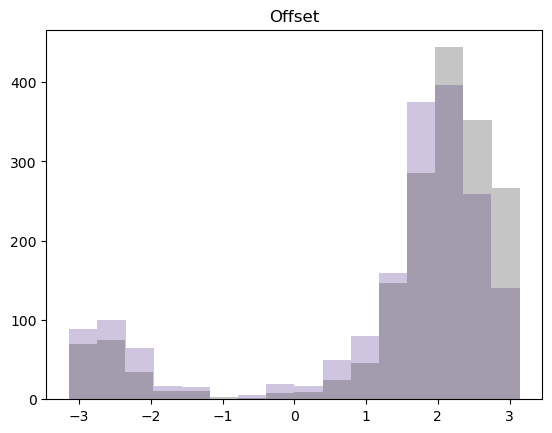

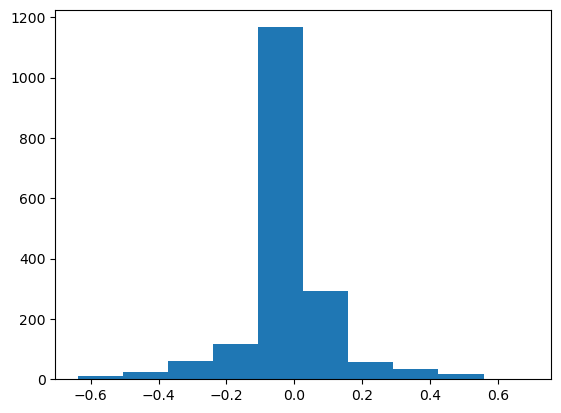

In [17]:
fig, ax= plt.subplots(4,1, figsize=[15,8], sharex=True)
fig.subplots_adjust(hspace=.5)
ax[0].imshow(y_sm[0,::-1,:]-y_sm[-1,:,:].mean(axis=0,keepdims=True), aspect='auto', cmap= 'Greys', vmin=-1, vmax=1)
ax[1].imshow(y_sm[1,::-1,:]-y_sm[-1,:,:].mean(axis=0,keepdims=True), aspect='auto', cmap= 'Purples', vmin=-1, vmax=1)

x = np.arange(y.shape[-1])

heading_ = 15-(heading+np.pi)/2/np.pi*15
ax[0].scatter(x,heading_, color='black',s=5)
ax[1].scatter(x,heading_, color='black', s=5)
ax[2].scatter(x, phi_green, color=plt.cm.Purples(.8))
ax[2].scatter(x, phi_red, color=plt.cm.Greys(.8))
ax[3].scatter(x, offset_green, color=plt.cm.Purples(.8))
ax[3].scatter(x, offset_red, color=plt.cm.Greys(.8))


fig, ax= plt.subplots()
ax.hist(np.angle(np.exp(1j*(phi_red-phi_green))))
ax.set_title('PVA diff')

fig, ax = plt.subplots()
bins = np.linspace(-np.pi, np.pi,num=16)
dh = np.unwrap(np.concatenate([[0,],np.diff(heading)]))
mask = (np.abs(heading)>.5) * (np.abs(dh)<.5)
ax.hist(offset_green, bins=16, color=plt.cm.Purples(.8),alpha=.3)
ax.hist(offset_red, bins=16, color=plt.cm.Greys(.8),alpha=.3)
ax.set_title('Offset')
print(sp.stats.circvar(offset_green[mask]))

fig, ax = plt.subplots()
ax.hist(dh)